# Assignment 4: Benchmarking Neural Nets with the XOR Problem

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For references, you may refer to my [lecture 10](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe) if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python/Tensorflow and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_4_ann.ipynb**.



In [2]:
# You might want to use the following packages
import numpy as np
import pandas as pd
import random
import os
import sklearn
%tensorflow_version 2.x
import tensorflow as tf

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

from sklearn.base import BaseEstimator
import math
from scipy.special import softmax

---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the train/validate/test set. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


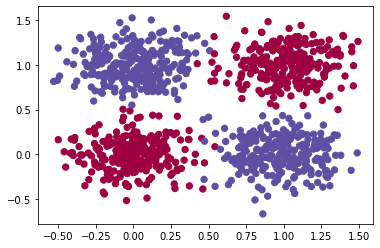

In [3]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49) 
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK (20 pts)

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [4]:
from tensorflow import keras

my_model = keras.Sequential()
my_model.add(keras.layers.Dense(2, input_dim=2, activation='relu'))
my_model.add(keras.layers.Dense(32, activation='relu'))
my_model.add(keras.layers.Dense(1, activation='sigmoid'))
my_model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

my_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

my_model.evaluate(x = X_test, y = y_test)

Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.2467 - accuracy: 0.6458 - val_loss: 0.2374 - val_accuracy: 0.7750
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2367 - accuracy: 0.6944 - val_loss: 0.2332 - val_accuracy: 0.7500
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2288 - accuracy: 0.7417 - val_loss: 0.2292 - val_accuracy: 0.6750
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2212 - accuracy: 0.7500 - val_loss: 0.2237 - val_accuracy: 0.6750
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.7514 - val_loss: 0.2173 - val_accuracy: 0.6750
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.7528 - val_loss: 0.2098 - val_accuracy: 0.6750
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.7542 - val_loss: 0.2011 - val_accuracy: 0.6750
Epoch 8/100
2

[0.014188225381076336, 0.9850000143051147]

- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK (60 pts)

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [5]:
class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, nn_input_dim, nn_hidden_dim, nn_output_dim, alpha=.001, epochs=100):
        """
        Initialize the network with random weights

        @param: nn_input_dim: Number of nodes in the input layer
        @param: nn_hidden_dim: Number of nodes in the hidden layer
        @param: nn_output_dim: Number of nodes in the output layer
        """
        # SUBTASK 1 (10 pts): Initialize the parameters to random values.
        np.random.seed(49)
        # There should be a total of input*output weights and as many bias terms (b)
        # as the number of nodes in that layer. Set Bias to zero when starting. Make
        # weights dimensions be number of nodes in current layer by number of nodes in 
        # previous layer  
        self.W1 = np.random.randn(nn_input_dim, nn_hidden_dim)
        self.b1 = np.zeros((1, nn_hidden_dim))
        self.W2 = np.random.randn(nn_hidden_dim, nn_output_dim)
        self.b2 = np.zeros((1, nn_output_dim))
        self.alpha = alpha
        self.epochs = epochs
        
    def loss(self, X, y):
        """
        Evaluate the average loss on the dataset
        """

        # Forward propagation will be needed to calculate the loss. A2 represents the 
        # probabilities of being a certain class (in the XOR problem, there are two classes)
        a1,a2 = self.forward_pass(X)
        # SUBTASK 2 (10 pts): Calculate the loss using log-loss probabilities using a2.
        # You will need to return the average loss on the data. 
        summer = 0 
        for i in range(len(y)):
          summer += y[i]*np.log(a2[i,1]) + (1-y[i])*np.log(1-a2[i,1])
        data_loss = -summer/len(y)
        return data_loss

    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature (a single column from X)
        @return: a1: saved value of the output of the hidden layer
        @return: a2: activated return value of the output layer.
        """
        # SUBTASK 3 (20 pts): Implement Forward propagation.
        # Note that you must implement tanh activiation for the hidden layer, and softmax for the output layer

        z1 = np.dot(X, self.W1) + self.b1
        a1 = np.tanh(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = softmax(z2, axis=1)

        return a1, a2 

    def backward_pass(self,a1,a2,X,y):
        """
        Pass the signal back and compute the gradient

        @param: X: feature
        @param: y: label
        @param: a1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the gradient of W1
        @return: db1: the gradient of b1
        @return: dW2: the gradient of W2
        @return: db2: the gradient of b2
        """
        # You do not have to change this function, ...
        # unless you are advanced and want to use different activation function.
        m = len(y) # number of example
        delta2 = a2
        y.astype(np.int64)
        delta2[range(m), y] -= 1
        dW2 = (a1.T).dot(delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = delta2.dot(self.W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0, keepdims=True)
        return dW1, db1, dW2, db2

    def fit(self, X, y, X_val, y_val):
        """
        Learns parameters for the neural network and returns the model.
        
        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        @param: alpha: the learning rate of your gradient descent
        """

        # Gradient descent. For each batch...
        for i in range(0, self.epochs):

            # Forward pass
            a1,a2 = self.forward_pass(X);

            # Backpropagation
            dW1, db1, dW2, db2 = self.backward_pass(a1,a2,X,y)

            # SUBTASK 4 (10 pts): Compute the gradient descent parameter update
            self.W1 += -self.alpha*dW1
            self.b1 += -self.alpha*db1
            self.W2 += -self.alpha*dW2
            self.b2 += -self.alpha*db2
        
            # Print the loss and validation accuracy at current epoch.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_acc: %f" 
                      %(i,
                        self.epochs, 
                        self.loss(X_train, y_train), 
                        self.evaluate(X_train, y_train),
                        self.loss(X_val, y_val), 
                        self.evaluate(X_val,y_val)))


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        y_pred = self.predict(X)
        return sum(y_pred == y)/len(y)

    def predict(self, X):
        """
        Predict an output

        @param: X: feature
        @return: y_pred: predicted label (0 or 1)
        """
        # SUBTASK 5 (10 pts): Implement the prediction process. 
        # Hint: It should include a forward pass, and then use the class with higher probability.
        a1, a2 = self.forward_pass(X);

        # Take the index of the max value between columns for the a2 array 
        y_pred = []
        for i in range(a2.shape[0]):
          if a2[i,0] > a2[i,1]:
            y_pred.append(0)
          else:
            y_pred.append(1)
        return y_pred


    def plot_decision_boundary(self, pred_func):
        """
        Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        Z = np.array(pred_func(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)
        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.show()


In [6]:
# Implement your own neural network 
net = MyNeuralNet(2, 4, 2, .001, 200)
net.fit(X_train, y_train, X_val, y_val)

Epoch 0/200 - loss: 0.850786 - accuracy: 0.300000 - val_loss: 0.811933 - val_acc: 0.375000
Epoch 10/200 - loss: 0.656237 - accuracy: 0.629167 - val_loss: 0.658872 - val_acc: 0.637500
Epoch 20/200 - loss: 0.567997 - accuracy: 0.573611 - val_loss: 0.588187 - val_acc: 0.562500
Epoch 30/200 - loss: 0.468086 - accuracy: 0.904167 - val_loss: 0.491767 - val_acc: 0.912500
Epoch 40/200 - loss: 0.334299 - accuracy: 0.984722 - val_loss: 0.358242 - val_acc: 0.987500
Epoch 50/200 - loss: 0.243370 - accuracy: 0.986111 - val_loss: 0.268614 - val_acc: 0.987500
Epoch 60/200 - loss: 0.185730 - accuracy: 0.983333 - val_loss: 0.208848 - val_acc: 0.987500
Epoch 70/200 - loss: 0.150051 - accuracy: 0.981944 - val_loss: 0.170537 - val_acc: 0.987500
Epoch 80/200 - loss: 0.127154 - accuracy: 0.981944 - val_loss: 0.145362 - val_acc: 0.987500
Epoch 90/200 - loss: 0.111701 - accuracy: 0.980556 - val_loss: 0.128107 - val_acc: 0.975000
Epoch 100/200 - loss: 0.100765 - accuracy: 0.980556 - val_loss: 0.115782 - val_ac

---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY (20 pts)
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version. 

Epoch 0/100 - loss: 0.850786 - accuracy: 0.300000 - val_loss: 0.811933 - val_acc: 0.375000
Epoch 10/100 - loss: 0.656237 - accuracy: 0.629167 - val_loss: 0.658872 - val_acc: 0.637500
Epoch 20/100 - loss: 0.567997 - accuracy: 0.573611 - val_loss: 0.588187 - val_acc: 0.562500
Epoch 30/100 - loss: 0.468086 - accuracy: 0.904167 - val_loss: 0.491767 - val_acc: 0.912500
Epoch 40/100 - loss: 0.334299 - accuracy: 0.984722 - val_loss: 0.358242 - val_acc: 0.987500
Epoch 50/100 - loss: 0.243370 - accuracy: 0.986111 - val_loss: 0.268614 - val_acc: 0.987500
Epoch 60/100 - loss: 0.185730 - accuracy: 0.983333 - val_loss: 0.208848 - val_acc: 0.987500
Epoch 70/100 - loss: 0.150051 - accuracy: 0.981944 - val_loss: 0.170537 - val_acc: 0.987500
Epoch 80/100 - loss: 0.127154 - accuracy: 0.981944 - val_loss: 0.145362 - val_acc: 0.987500
Epoch 90/100 - loss: 0.111701 - accuracy: 0.980556 - val_loss: 0.128107 - val_acc: 0.975000


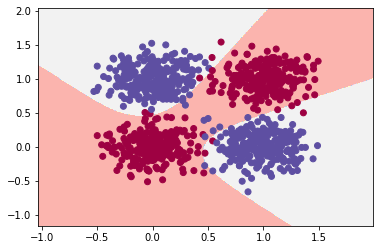

Weights of first layer:
 [[ 1.30251216 -1.64889731  2.00521984  2.73350162]
 [-2.44694082 -1.54067104  1.94413677 -1.54753173]] 

Bias of first layer:
 [[-0.30742614 -0.02198771 -0.29134965  0.49245737]] 

Weights of second layer:
 [[-1.10750049  2.90142245]
 [ 1.68150605 -0.57502423]
 [-1.43831786  1.56055431]
 [ 0.97571646 -3.11368908]] 

Bias of second layer:
 [[ 0.27111051 -0.27111051]] 

Epoch 0/100 - loss: 0.702951 - accuracy: 0.381944 - val_loss: 0.724051 - val_acc: 0.350000
Epoch 10/100 - loss: 0.638658 - accuracy: 0.641667 - val_loss: 0.664431 - val_acc: 0.575000
Epoch 20/100 - loss: 0.568131 - accuracy: 0.672222 - val_loss: 0.603535 - val_acc: 0.612500
Epoch 30/100 - loss: 0.515155 - accuracy: 0.683333 - val_loss: 0.555859 - val_acc: 0.625000
Epoch 40/100 - loss: 0.481664 - accuracy: 0.687500 - val_loss: 0.525092 - val_acc: 0.625000
Epoch 50/100 - loss: 0.459170 - accuracy: 0.693056 - val_loss: 0.504266 - val_acc: 0.625000
Epoch 60/100 - loss: 0.441913 - accuracy: 0.701389 - 

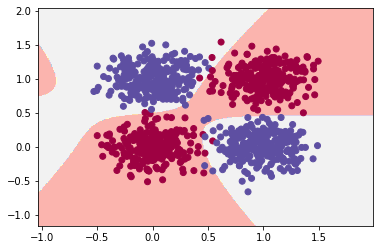

Weights of first layer:
 [[-2.38429145 -2.05724513  0.01345549  1.89498305 -2.70072899]
 [-1.34480297  1.07696155  1.30837039  0.15346554  1.78708099]] 

Bias of first layer:
 [[ 0.29241874 -0.98213941 -0.61179232 -0.04652062 -1.18240175]] 

Weights of second layer:
 [[ 2.18646707 -1.07998525]
 [-0.86280401  0.98504047]
 [ 0.04174719 -2.17971982]
 [ 0.64225292  1.44773276]
 [-0.89009126  1.62533675]] 

Bias of second layer:
 [[-0.14810993  0.14810993]] 

Epoch 0/100 - loss: 0.609067 - accuracy: 0.806944 - val_loss: 0.616572 - val_acc: 0.750000
Epoch 10/100 - loss: 0.392290 - accuracy: 0.984722 - val_loss: 0.417441 - val_acc: 0.987500
Epoch 20/100 - loss: 0.276497 - accuracy: 0.986111 - val_loss: 0.302626 - val_acc: 0.987500
Epoch 30/100 - loss: 0.205495 - accuracy: 0.984722 - val_loss: 0.230122 - val_acc: 0.987500
Epoch 40/100 - loss: 0.161986 - accuracy: 0.983333 - val_loss: 0.184493 - val_acc: 0.987500
Epoch 50/100 - loss: 0.134305 - accuracy: 0.981944 - val_loss: 0.154861 - val_acc:

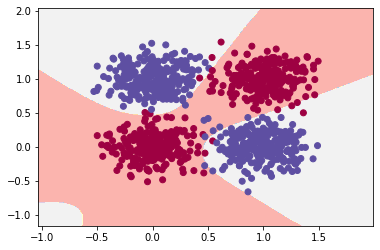

Weights of first layer:
 [[-2.47711704 -1.06255538  0.80704625  2.49318922 -1.90118314 -0.07101601]
 [ 1.4724635   0.25031055 -0.03556518  2.43050284  2.79728315 -0.57346762]] 

Bias of first layer:
 [[-0.50033581  0.13464225 -0.25838362 -0.68556858  0.6911873   0.29851238]] 

Weights of second layer:
 [[-1.79921391  1.92145036]
 [-1.54186671 -0.59610592]
 [ 1.46099875  0.62898693]
 [-1.75186193  2.48710741]
 [ 0.6435712  -3.50157309]
 [-0.42402872  0.57091898]] 

Bias of second layer:
 [[-0.46939317  0.46939317]] 

Epoch 0/100 - loss: 0.708956 - accuracy: 0.459722 - val_loss: 0.689378 - val_acc: 0.537500
Epoch 10/100 - loss: 0.576094 - accuracy: 0.722222 - val_loss: 0.587705 - val_acc: 0.762500
Epoch 20/100 - loss: 0.465816 - accuracy: 0.926389 - val_loss: 0.488938 - val_acc: 0.912500
Epoch 30/100 - loss: 0.361272 - accuracy: 0.968056 - val_loss: 0.388782 - val_acc: 0.950000
Epoch 40/100 - loss: 0.272661 - accuracy: 0.975000 - val_loss: 0.302531 - val_acc: 0.975000
Epoch 50/100 - loss

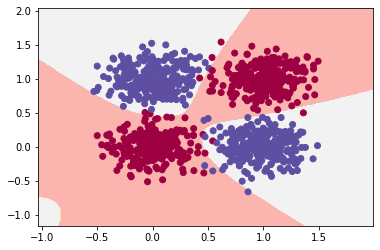

Weights of first layer:
 [[-1.62028568 -1.0160728   2.33562429  2.07190993 -2.25706114  1.12972899
  -0.27796885]
 [ 0.64699236  0.10204093  2.31821272  1.85546105  1.22577896 -2.06527437
   1.47359059]] 

Bias of first layer:
 [[-0.15156293  0.19890263 -0.62945652 -0.32470945 -0.42095918 -0.35234357
  -0.28721583]] 

Weights of second layer:
 [[-1.9416814  -0.19629123]
 [ 0.51621865  1.57376704]
 [-1.52290062  2.25814611]
 [-2.65807845 -0.19992344]
 [-1.42957554  1.57646579]
 [-1.88312527  1.1946159 ]
 [ 1.22647055 -1.08989313]] 

Bias of second layer:
 [[ 0.10100483 -0.10100483]] 

Epoch 0/100 - loss: 0.912336 - accuracy: 0.459722 - val_loss: 0.875902 - val_acc: 0.462500
Epoch 10/100 - loss: 0.498372 - accuracy: 0.918056 - val_loss: 0.512074 - val_acc: 0.925000
Epoch 20/100 - loss: 0.323394 - accuracy: 0.968056 - val_loss: 0.344313 - val_acc: 0.987500
Epoch 30/100 - loss: 0.228793 - accuracy: 0.976389 - val_loss: 0.248622 - val_acc: 1.000000
Epoch 40/100 - loss: 0.176221 - accuracy: 

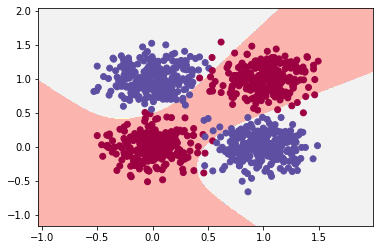

Weights of first layer:
 [[-1.17000482 -2.74641797  1.48981878  1.84767135 -1.63751254  0.2436471
   0.39134529  1.67894642]
 [ 0.20196884  1.97925556  1.82711655  0.78583008 -1.28902078  0.46645964
  -1.11596696 -2.43154919]] 

Bias of first layer:
 [[ 0.14880039 -0.90189026 -0.23338062  0.16647345  0.07260574 -0.27007049
  -0.01624365 -0.66243017]] 

Weights of second layer:
 [[ 0.54825636  1.54172932]
 [-1.84035164  2.57559713]
 [-2.62296242 -0.23503947]
 [-0.4147585   0.56164876]
 [ 0.51110188 -1.19961124]
 [ 0.40075858 -0.26418117]
 [ 0.30267095  1.1233661 ]
 [-1.82105228  2.39610955]] 

Bias of second layer:
 [[-0.49119807  0.49119807]] 



In [9]:
# MODEL 1: layers {2, 4, 2} with epoch of 100 and learning rate of .001

# Build a model with 3 layers: 2 in the first, 4 in the second and 2 in the third. 
# Run over 100 epochs (an epoch is just number of BGD iterations)
myModel1 = MyNeuralNet(2, 4, 2);
myModel1.fit(X_train, y_train, X_val, y_val)

# Plot the decision boundary
myModel1.plot_decision_boundary(lambda x: myModel1.predict(x))

# See the weights and biases of the network
print("Weights of first layer:\n", myModel1.W1, '\n')
print("Bias of first layer:\n",myModel1.b1, '\n')
print("Weights of second layer:\n", myModel1.W2, '\n')
print("Bias of second layer:\n",myModel1.b2, '\n')


# MODEL 2: layers {2, 5, 2} with epoch 100 and learning rate of .001
myModel2 = MyNeuralNet(2, 5, 2);
myModel2.fit(X_train, y_train, X_val, y_val)
myModel2.plot_decision_boundary(lambda x: myModel2.predict(x))
print("Weights of first layer:\n", myModel2.W1, '\n')
print("Bias of first layer:\n",myModel2.b1, '\n')
print("Weights of second layer:\n", myModel2.W2, '\n')
print("Bias of second layer:\n",myModel2.b2, '\n')


# MODEL 3: layers {2, 6, 2} with epoch 100 and learning rate of .001
myModel3 = MyNeuralNet(2, 6, 2);
myModel3.fit(X_train, y_train, X_val, y_val)
myModel3.plot_decision_boundary(lambda x: myModel3.predict(x))
print("Weights of first layer:\n", myModel3.W1, '\n')
print("Bias of first layer:\n",myModel3.b1, '\n')
print("Weights of second layer:\n", myModel3.W2, '\n')
print("Bias of second layer:\n",myModel3.b2, '\n')


# MODEL 4: layers {2, 7, 2} with epoch 100 and learning rate of .001
myModel4 = MyNeuralNet(2, 7, 2);
myModel4.fit(X_train, y_train, X_val, y_val)
myModel4.plot_decision_boundary(lambda x: myModel4.predict(x))
print("Weights of first layer:\n", myModel4.W1, '\n')
print("Bias of first layer:\n",myModel4.b1, '\n')
print("Weights of second layer:\n", myModel4.W2, '\n')
print("Bias of second layer:\n",myModel4.b2, '\n')


# MODEL 5: layers {2, 8, 2} with epoch 100 and learning rate of .001
myModel5 = MyNeuralNet(2, 8, 2);
myModel5.fit(X_train, y_train, X_val, y_val)
myModel5.plot_decision_boundary(lambda x: myModel5.predict(x))
print("Weights of first layer:\n", myModel5.W1, '\n')
print("Bias of first layer:\n",myModel5.b1, '\n')
print("Weights of second layer:\n", myModel5.W2, '\n')
print("Bias of second layer:\n",myModel5.b2, '\n')


In [11]:
# I could not get GridCSV to work for me so I had to do a lil manual hyperparameter tuning
alphas = [.001, .005, .01, .1]
epochs = [100, 200, 300, 400, 500]
hidden = [2, 3, 4, 5, 6, 7, 8]

best_alpha = None
best_epoch = None
best_hidden = None
accuracy = 0

for h in hidden:
  for a in alphas: 
    for e in epochs: 
      net = MyNeuralNet(2,h,2,a,e)
      net.fit(X_train, y_train, X_val, y_val)
      eval = net.evaluate(X_train, y_train)
      if eval > accuracy:
        accuracy = eval
        best_alpha = a
        best_epoch = e
        best_hidden = h
      print('\nAccuracy: ',net.evaluate(X_val, y_val),
            '\nAlpha: ',a,
            '\nEpoch: ',e, 
            '\nHidden: ',h,
            '\n')

Epoch 0/100 - loss: 0.690779 - accuracy: 0.658333 - val_loss: 0.759356 - val_acc: 0.612500
Epoch 10/100 - loss: 0.566537 - accuracy: 0.769444 - val_loss: 0.591937 - val_acc: 0.712500
Epoch 20/100 - loss: 0.446314 - accuracy: 0.902778 - val_loss: 0.470828 - val_acc: 0.862500
Epoch 30/100 - loss: 0.341131 - accuracy: 0.934722 - val_loss: 0.362718 - val_acc: 0.937500
Epoch 40/100 - loss: 0.271568 - accuracy: 0.944444 - val_loss: 0.288707 - val_acc: 0.950000
Epoch 50/100 - loss: 0.228643 - accuracy: 0.948611 - val_loss: 0.241383 - val_acc: 0.937500
Epoch 60/100 - loss: 0.201620 - accuracy: 0.947222 - val_loss: 0.210665 - val_acc: 0.937500
Epoch 70/100 - loss: 0.183877 - accuracy: 0.950000 - val_loss: 0.189982 - val_acc: 0.925000
Epoch 80/100 - loss: 0.171721 - accuracy: 0.948611 - val_loss: 0.175510 - val_acc: 0.937500
Epoch 90/100 - loss: 0.163078 - accuracy: 0.951389 - val_loss: 0.165026 - val_acc: 0.937500

Accuracy:  0.9375 
Alpha:  0.001 
Epoch:  100 
Hidden:  2 

Epoch 0/200 - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply


Epoch 10/100 - loss: nan - accuracy: 0.486111 - val_loss: nan - val_acc: 0.587500
Epoch 20/100 - loss: 17.097630 - accuracy: 0.486111 - val_loss: 13.724314 - val_acc: 0.587500
Epoch 30/100 - loss: 28.118428 - accuracy: 0.513889 - val_loss: 33.983128 - val_acc: 0.412500
Epoch 40/100 - loss: 57.285088 - accuracy: 0.513889 - val_loss: 69.233120 - val_acc: 0.412500
Epoch 50/100 - loss: 86.451748 - accuracy: 0.513889 - val_loss: 104.483112 - val_acc: 0.412500
Epoch 60/100 - loss: nan - accuracy: 0.486111 - val_loss: nan - val_acc: 0.587500
Epoch 70/100 - loss: nan - accuracy: 0.486111 - val_loss: nan - val_acc: 0.587500
Epoch 80/100 - loss: nan - accuracy: 0.486111 - val_loss: nan - val_acc: 0.587500
Epoch 90/100 - loss: 2.101464 - accuracy: 0.486111 - val_loss: 1.690239 - val_acc: 0.587500

Accuracy:  0.5875 
Alpha:  0.1 
Epoch:  100 
Hidden:  2 

Epoch 0/200 - loss: 3.708990 - accuracy: 0.281944 - val_loss: 3.616071 - val_acc: 0.362500
Epoch 10/200 - loss: nan - accuracy: 0.486111 - val_l

In [12]:
# Print out the best parameters for our model
print("Best Alpha: ", best_alpha, 
      "\nBest epochs: ",best_epoch,
      "\nBest hidden layers: ",best_hidden,
      "\nAccuracy of:",accuracy)

Best Alpha:  0.005 
Best epochs:  500 
Best hidden layers:  4 
Accuracy of: 0.9972222222222222


In [13]:
# Evaluate the test data on the optimal model
net = MyNeuralNet(2,8,2,.005,400)
net.fit(X_train, y_train, X_val, y_val)
print("\nAccuracy of my model on test data: ",net.evaluate(X_test, y_test))

Epoch 0/400 - loss: 2.372362 - accuracy: 0.495833 - val_loss: 1.919312 - val_acc: 0.600000
Epoch 10/400 - loss: 2.965190 - accuracy: 0.486111 - val_loss: 2.405439 - val_acc: 0.587500
Epoch 20/400 - loss: 2.021512 - accuracy: 0.547222 - val_loss: 1.655895 - val_acc: 0.612500
Epoch 30/400 - loss: 0.066578 - accuracy: 0.976389 - val_loss: 0.067594 - val_acc: 0.962500
Epoch 40/400 - loss: 0.059896 - accuracy: 0.977778 - val_loss: 0.062381 - val_acc: 0.962500
Epoch 50/400 - loss: 0.055985 - accuracy: 0.977778 - val_loss: 0.061325 - val_acc: 0.975000
Epoch 60/400 - loss: 0.053387 - accuracy: 0.979167 - val_loss: 0.059234 - val_acc: 0.975000
Epoch 70/400 - loss: 0.051281 - accuracy: 0.979167 - val_loss: 0.056876 - val_acc: 0.987500
Epoch 80/400 - loss: 0.049401 - accuracy: 0.979167 - val_loss: 0.054711 - val_acc: 0.975000
Epoch 90/400 - loss: 0.047675 - accuracy: 0.979167 - val_loss: 0.052823 - val_acc: 0.975000
Epoch 100/400 - loss: 0.046053 - accuracy: 0.980556 - val_loss: 0.051182 - val_ac

In [14]:
# COMPARISONS WITH THE STANDARD LIBRARY 
my_model = keras.Sequential()
my_model.add(keras.layers.Dense(2, input_dim=2, activation='tanh'))
my_model.add(keras.layers.Dense(8, activation='tanh'))
my_model.add(keras.layers.Dense(2, activation='softmax'))
my_model.compile(loss='binary_crossentropy',
                 metrics=['accuracy'])

my_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 400)
my_model.evaluate(x = X_test, y = y_test)

Epoch 1/400
23/23 [==============================] - 0s 7ms/step - loss: 0.6968 - accuracy: 0.4667 - val_loss: 0.6962 - val_accuracy: 0.5375
Epoch 2/400
23/23 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.5222 - val_loss: 0.6947 - val_accuracy: 0.5500
Epoch 3/400
23/23 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.5361 - val_loss: 0.6938 - val_accuracy: 0.4000
Epoch 4/400
23/23 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5208 - val_loss: 0.6934 - val_accuracy: 0.5250
Epoch 5/400
23/23 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5181 - val_loss: 0.6932 - val_accuracy: 0.5375
Epoch 6/400
23/23 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5097 - val_loss: 0.6932 - val_accuracy: 0.5250
Epoch 7/400
23/23 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5125 - val_loss: 0.6932 - val_accuracy: 0.4625
Epoch 8/400
2

[0.6931471228599548, 0.5149999856948853]

## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

Implementing the Neural Network was significantly easier than SVM and was a little more intuitive. The majority of the code could be directly translated from the slides and applied to the myNeuralNetwork class that we created. The part in which I learned the most was probably setting the initial dimensions of the weights and biases vectors: this required me to understand how a neural network works and how the data progates through the network. I am not sure why I coud not get the keras neural network to produce the same precision as my hand implemented version as I used the same activation functions (tanh and softmax) and binary crossentropy for my loss function. I would have liked to discuss my implemetation in office hours but never got a chance: I would love if you all could add some comments on why I am recieving such wack accuracy and loss and what I could change to get results more consistent with my implementation :).  

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [lecture 10](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe)
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 4:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!